In [ ]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
import numpy as np
import random
import re

from collections import defaultdict
from torch.nn.utils.rnn import pad_sequence
from torch import nn
from math import sqrt
from torch.optim import Adam
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt


# ds = load_dataset("stanfordnlp/imdb")
train_ds = load_dataset("stanfordnlp/imdb", split="train[:100%]")
test_ds = load_dataset("stanfordnlp/imdb", split="test[:100%]")

tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')

def is_punctuation_only(token):
    return re.fullmatch(r'[^\w\s]+', token) is not None

def simple_eda(text, label_token, p=0.1):
    if is_punctuation_only(label_token):
        return text  # 증강 안 하고 원문 반환

    words = text.split()
    if len(words) < 4:
        return text

    # 단어 삭제
    new_words = [w for w in words if random.random() > p]

    # 단어 순서 바꾸기
    if len(new_words) > 1:
        i = random.randint(0, len(new_words)-2)
        new_words[i], new_words[i+1] = new_words[i+1], new_words[i]

    return ' '.join(new_words)

# 정답 레이블이 한쪽으로 치우칠 경우를 대비한 작업
def make_balanced_subset(dataset, max_per_label=500):
    label_to_examples = defaultdict(list)

    for row in dataset:
        input_ids = tokenizer(row['text'], truncation=True, max_length=400).input_ids
        if len(input_ids) < 3:
            continue

        label_id = input_ids[-3]
        label_token = tokenizer.convert_ids_to_tokens([label_id])[0]
        label_to_examples[label_token].append(row)

    balanced_subset = []
    for label, examples in label_to_examples.items():
        if len(examples) > max_per_label:
            examples = random.sample(examples, max_per_label)
        balanced_subset.extend(examples)

    random.shuffle(balanced_subset)
    return balanced_subset

# 약간의 데이터 증강, 노이즈 추가를 통한 과적합 방지
def augment_dataset(dataset, augment_prob=0.1):
    augmented = []

    for row in dataset:
        input_ids = tokenizer(row['text'], truncation=True, max_length=400).input_ids
        if len(input_ids) < 3:
            continue

        label_id = input_ids[-3]
        label_token = tokenizer.convert_ids_to_tokens([label_id])[0]

        augmented.append(row)  # 원본 추가

        # 증강 조건
        if random.random() < augment_prob and not is_punctuation_only(label_token):
            aug_text = simple_eda(row['text'], label_token)
            augmented.append({'text': aug_text})

    random.shuffle(augmented)
    return augmented

balanced_train_ds = make_balanced_subset(train_ds, max_per_label=500)
augmented_train_ds = augment_dataset(balanced_train_ds, augment_prob=0.1)

def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[-3])
    texts.append(torch.LongTensor(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[:-3]))

  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)

  return texts, labels

# 학습 데이터에 대해서만 증강과 밸런싱을 진행
train_loader = DataLoader(
    augmented_train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn
)

test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn
)

Using cache found in C:\Users\admin/.cache\torch\hub\huggingface_pytorch-transformers_main




# 발생 했던 문제 상황


---


##   1. "."으로 찍음

초기에 과제가
```
labels.append(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[-2])
texts.append(torch.LongTensor(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[:-2]))
```
이였을 때, 정답 레이블의 대부분이 "." 이었다. 이로 인해 인공지능은 "." 으로 찍기만 해도 약 60% 의 정확도를 보일 수 있었고, 이는 인공지능에게 강한 편향으로 작용했다.

이진 분류 문제로 치자면, 고양이 사진이 99.9%, 강아지 사진이 0.1%로 구성된 데이터 셋을 생각할 수 있다. 이런 데이터 셋에서는 전부 고양이라고 주장하는 것 만으로도 99.9% 의 정확도를 보인다. 따라서 인공지능은 고양이와 강아지를 구분하는 방향이 아니라 무조건 고양이라고 주장하는 방향으로 학습한다.

이렇게 편향적인 데이터 셋에 경우 정답 레이블이 "." 인 데이터를 버려서라도 레이블의 비율을 밸런싱 하는 것이 중요하다고 생각한다. 따라서 make_balanced_subset 함수를 이용해 같은 정답 레이블을 가진 데이터가 일정 수를 넘지 못하도록 조정했다.


##   2. 과적합

Train 데이터에 대해서는 95% 이상의 정확도에 도달하는 것에도 성공하였으나, 이 경우 Test 데이터에 정확도는 약 10% 였다. 이는 과적합으로, 인공지능이 문맥을 이해하기 보다는 Train 데이터에 있는 문장들을 암기한 것에 가까웠다.

따라서 여러가지 기법들을 사용해 이런 과적합을 줄이고자 했다.

# 사용된 과적합 방지 기법


---


## 1.   Augment Dataset

통상 과적합은 모델이 복잡한것에 비해 데이터가 부족할 때 일어난다. 따라서 데이터 증강을 하고자 한다. 가장 강력하다고 생각되는 데이터 증강 기법은 동의어로 대체하기였다. 하지만 동의어를 찾기 위해서는 별도의 언어 모델이 필요하다. 이는 언어 모델을 만들기 위해 또다른 언어 모델이 필요한 이슈를 만들어, 적용하지 않았다.

대신 문장에서 무작위 단어를 삭제하거나 순서를 바꾸는 방향을 택했다. 이는 아주 위험한 방법이다. 왜냐하면 positional_encoding 을 통해 애써 주입한 위치 정보를 무의미하게 만들거나, 문맥에 주요한 단어를 삭제해 이해력을 떨어트릴 수 있기 때문이다.

하지만 이러한 데이터 증강을 적용하기로 결정했다. 그것은 과적합을 막기 위함인데, 의도적으로 노이즈에 가까운 데이터를 추가하는 것이 과적합을 줄이는데 도움을 줄 수 있다.


## 2.   Dropout

1주차 과제에서도 사용했던 기법이다. 뉴런의 일부를 비활성화 시켜 과적합을 방지한다.


## 3. Label Smoothing

One-hot 인코딩이 이루어진 레이블에서 사용하기 좋은 방법이다. Softmax를 통과한 확률 분포를 좀 더 부드럽게 만든다. 예를 들어 [0, 0, 1, 0] 를 [0.05, 0.05, 0.85, 0.05] 로 변형하는 식이다. [0, 0, 1, 0] 과 같은 지나친 확신은 과적합의 결과일 수 있으므로 이를 예방해준다.


## 4. Weight Decay

파라미터 값을 감소시켜 과적합을 방지한다. 너무 큰 가중치는 지나친 편향을 만들어 과적합을 유발할 수 있기 때문이다.

In [ ]:

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()

        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads

        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        self.dense = nn.Linear(d_model, d_model)

        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(0.3)
        self.norm = nn.LayerNorm(d_model)

    def split_heads(self, x, batch_size):
        return x.view(batch_size, -1, self.num_heads, self.depth).transpose(1, 2)

    # residual 적용
    def forward(self, x, mask):
        batch_size = x.size(0)
        residual = x

        q = self.wq(x)
        k = self.wk(x)
        v = self.wv(x)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        score = torch.matmul(q, k.transpose(-1, -2)) / sqrt(self.depth)

        if mask is not None:
            mask = mask.unsqueeze(1)
            score = score + (mask * -1e9)

        attn_weights = self.softmax(score)
        attn_output = torch.matmul(attn_weights, v)

        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        attn_output = self.dense(attn_output)

        x = residual + self.dropout(attn_output)
        x = self.norm(x)
        return x

class TransformerLayer(nn.Module):
    def __init__(self, input_dim, d_model, dff, num_heads=8):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model
        self.dff = dff

        self.mha = MultiHeadSelfAttention(d_model, num_heads)  # 변경됨
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model)
        )

        # 레이어 Norm, Dropout 적용
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)

    def forward(self, x, mask):
        attn_output = self.mha(x, mask)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)

        ffn_output = self.ffn(x)
        x = x + self.dropout2(ffn_output)
        x = self.norm2(x)

        return x


def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
  pos_encoding = angle_rads[None, ...]

  return torch.FloatTensor(pos_encoding)

max_len = 400
print(positional_encoding(max_len, 64).shape)

class WordPredictor(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, dff):
        super().__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.dff = dff

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
        self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])
        self.classification = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        mask = (x == tokenizer.pad_token_id)
        seq_len = x.shape[1]

        lengths = (x != tokenizer.pad_token_id).sum(dim=1)

        mask = mask[:, None, :]

        x = self.embedding(x)
        x = x * sqrt(self.d_model)
        x = x + self.pos_encoding[:, :seq_len].to(x.device)

        for layer in self.layers:
            x = layer(x, mask)

        last_token_indices = lengths - 1
        batch_size = x.shape[0]
        last_outputs = x[torch.arange(batch_size), last_token_indices]

        x = self.classification(last_outputs)
        return x

    # Layer-wise Training 적용
    def add_layer(self):
        new_layer = TransformerLayer(self.d_model, self.d_model, self.dff).to(next(self.parameters()).device)
        self.layers.append(new_layer)
        print(f">>> [Layer Added] 현재 레이어 수: {len(self.layers)}")


model = WordPredictor(len(tokenizer), 64, 1, 128)

lr = 0.001
model = model.to('cuda')

# Label Smoothing 적용
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

# Weight Decay 적용
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-4)

def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    all_preds = []
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)
        preds = torch.argmax(preds, dim=-1)
        # preds = (preds > 0).long()[..., 0]

        cnt += labels.shape[0]
        acc += (labels == preds).sum().item()
    return acc / cnt

train_accuracies = []
test_accuracies = []

torch.Size([1, 400, 64])


# 기타 기법


---



## 1.   Layer-wise Training

레이어를 학습 과정에서 순차적으로 쌓아주는 것을 말한다. 예를들어 처음부터 6층의 모델로 시작하는 것이 아니라, 1 층에서 시작하여 5 epoch 마다 층을 쌓아 주는 것이다. 이는 층이 깊을 때 생겨나는 기울이 폭발이나 소실 문제를 줄여준다. 또한 몇층의 모델이 가장 좋은 성능을 내는지 추측하는 것에 도움을 준다.

## 2.   Layer Normalization

Batch Normalization 과 비슷하게 내부 공변량을 줄여 학습을 안정시킨다.

## 3.   Residual Connection

레이어의 입력을 출력에 그대로 더해준다. 기울기 소실을 방지하고 정보를 보존해준다.

Epoch   0 | Train Loss: 3257.437114238739
=========> Train acc: 0.127 | Test acc: 0.155

[Epoch 0] 예측 결과:
  예측: ,               | 정답: is
  예측: /               | 정답: ##orn
  예측: movie           | 정답: film
  예측: movie           | 정답: surroundings
  예측: movie           | 정답: second
  예측: of              | 정답: not
  예측: .               | 정답: seriously
  예측: it              | 정답: it
  예측: it              | 정답: to
  예측: movie           | 정답: 3
  예측: it              | 정답: opinion
  예측: it              | 정답: stuff
  예측: movie           | 정답: mildly
  예측: it              | 정답: plot
  예측: .               | 정답: 99
  예측: )               | 정답: his
  예측: this            | 정답: that
  예측: /               | 정답: instead
  예측: it              | 정답: c
  예측: 10              | 정답: 2
--------------------------------------------------
Epoch   1 | Train Loss: 2787.8094329833984
=========> Train acc: 0.157 | Test acc: 0.174

[Epoch 1] 예측 결과:
  예측: the             | 정답: the
  예측: the             | 정답: a
  예측: op

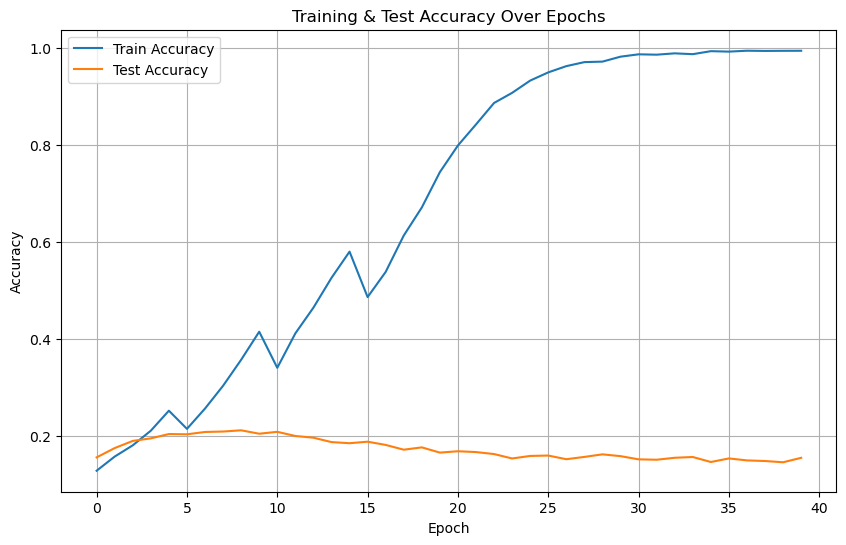

In [ ]:
n_epochs = 40
for epoch in range(n_epochs):

    if (epoch == 5) or (epoch == 10) or (epoch == 15):
        model.add_layer()
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    total_loss = 0.
    model.train()

    scaler = GradScaler()

    for step, data in enumerate(train_loader):
        model.zero_grad()
        inputs, labels = data
        if inputs.shape[0] == 0:
            continue
        inputs, labels = inputs.to('cuda'), labels.to('cuda').long()

        with autocast():
            preds = model(inputs)
            pred_ids = torch.argmax(preds, dim=-1)

            loss = loss_fn(preds, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

    print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

    if epoch % 1 == 0:
        with torch.no_grad():
            model.eval()
            train_acc = accuracy(model, train_loader)
            test_acc = accuracy(model, test_loader)

            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

            # 무작위 예측 결과 20개 출력 (정답이 특수문자가 아닌 것만)
            valid_samples = []
            for data in test_loader:
                inputs, labels = data
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
                preds = model(inputs)
                pred_ids = torch.argmax(preds, dim=-1)

                pred_tokens = tokenizer.convert_ids_to_tokens(pred_ids.tolist())
                true_tokens = tokenizer.convert_ids_to_tokens(labels.tolist())

                for i in range(len(true_tokens)):
                    if not is_punctuation_only(true_tokens[i]):
                        valid_samples.append((pred_tokens[i], true_tokens[i]))
                    if len(valid_samples) >= 100:
                        break
                if len(valid_samples) >= 100:
                    break

            sample_to_show = random.sample(valid_samples, min(20, len(valid_samples)))

            print(f"\n[Epoch {epoch}] 예측 결과:")
            for pred_token, true_token in sample_to_show:
                print(f"  예측: {pred_token:15} | 정답: {true_token}")
            print("-" * 50)

# 정확도 그래프
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Test Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# 결론


---

다양한 정규화 방법을 쓰고도 정확도는 높지 않았다.아마 30000개가 넘는 단어중 하나를 맞춘다는 문제 난이도 자체가 너무 높지 않았나 싶다. 약 10 epoch 에서 21% 정도의 정확도를 보여줬다. 이후 Test Data에서 정확도 감소가 나타나는 것으로 보아 과적합이 발생한 것으로 보인다.